# ¿Cuál es un mejor plan?

La empresa de telecomunicaciones Megaline ofrece a sus clientes dos tarifas de prepago, Surf y Ultimate. El departamento comercial quiere saber cuál de los planes genera más ingresos para poder ajustar el presupuesto de publicidad.

Se realiza un análisis preliminar de las tarifas basado en una selección de clientes relativamente pequeña. Se tienen los datos de 500 clientes de Megaline que incluyen: quiénes son los clientes, de dónde son, qué tarifa usan, así como la cantidad de llamadas que hicieron y los mensajes de texto que enviaron en 2018. Estos datos se usan para analizar el comportamiento de los clientes y determinar qué tarifa de prepago genera más ingresos.

## Inicialización

In [1]:
# Cargar todas las librerías
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import numpy as np
from scipy import stats as st

## Inicialización y vista general

In [2]:
# Cargar los archivos de datos en diferentes DataFrames
df_calls = pd.read_csv('/datasets/megaline_calls.csv')
df_int   = pd.read_csv('/datasets/megaline_internet.csv')
df_mess  = pd.read_csv('/datasets/megaline_messages.csv') 
df_plans = pd.read_csv('/datasets/megaline_plans.csv')
df_users = pd.read_csv('/datasets/megaline_users.csv')

Se explora cada una de las tablas para tener una comprensión inicial de los datos y se hacen las correcciones necesarias.

In [3]:
#información general
for df in [df_calls, df_int, df_mess, df_plans, df_users]:
    df.info()
    print()

<class 'pandas.core.frame.DataFrame'>

RangeIndex: 137735 entries, 0 to 137734

Data columns (total 4 columns):

 #   Column     Non-Null Count   Dtype  

---  ------     --------------   -----  

 0   id         137735 non-null  object 

 1   user_id    137735 non-null  int64  

 2   call_date  137735 non-null  object 

 3   duration   137735 non-null  float64

dtypes: float64(1), int64(1), object(2)

memory usage: 4.2+ MB



<class 'pandas.core.frame.DataFrame'>

RangeIndex: 104825 entries, 0 to 104824

Data columns (total 4 columns):

 #   Column        Non-Null Count   Dtype  

---  ------        --------------   -----  

 0   id            104825 non-null  object 

 1   user_id       104825 non-null  int64  

 2   session_date  104825 non-null  object 

 3   mb_used       104825 non-null  float64

dtypes: float64(1), int64(1), object(2)

memory usage: 3.2+ MB



<class 'pandas.core.frame.DataFrame'>

RangeIndex: 76051 entries, 0 to 76050

Data columns (total 3 columns):

 #   Colu

In [4]:
#buscar datos duplicados
for df in [df_calls, df_int, df_mess]:
    print(df['id'].duplicated().value_counts())
    print()

False    137735

Name: id, dtype: int64



False    104825

Name: id, dtype: int64



False    76051

Name: id, dtype: int64




In [5]:
#Se buscan filas duplicadas por medio de los ids únicos
df_users['user_id'].duplicated().value_counts()

False    500
Name: user_id, dtype: int64

No se encuentran valores duplicados ni ausentes en las tablas a excepción de los valores ausentes de la última tabla.

La columna `churn_date` de la tabla de los usuarios representa la fecha en que el usuario dejo de usar el servicio. La ausencia significa que se sigue usando y esto no afecta el análisis.

In [6]:
# se corrige el tipo de dato de las columnas que son fechas
df_calls['call_date']   = pd.to_datetime(df_calls['call_date'], format='%Y-%m-%d')
df_int['session_date']  = pd.to_datetime(df_int['session_date'], format='%Y-%m-%d')
df_mess['message_date'] = pd.to_datetime(df_mess['message_date'], format='%Y-%m-%d')
df_users['reg_date']    = pd.to_datetime(df_users['reg_date'], format='%Y-%m-%d')
df_users['churn_date']  = pd.to_datetime(df_users['churn_date'], format='%Y-%m-%d')

In [7]:
#comprobar cambios de tipo de datos a fecha
for df in [df_calls, df_int, df_mess, df_plans, df_users]:
    df.info()
    print()

<class 'pandas.core.frame.DataFrame'>

RangeIndex: 137735 entries, 0 to 137734

Data columns (total 4 columns):

 #   Column     Non-Null Count   Dtype         

---  ------     --------------   -----         

 0   id         137735 non-null  object        

 1   user_id    137735 non-null  int64         

 2   call_date  137735 non-null  datetime64[ns]

 3   duration   137735 non-null  float64       

dtypes: datetime64[ns](1), float64(1), int64(1), object(1)

memory usage: 4.2+ MB



<class 'pandas.core.frame.DataFrame'>

RangeIndex: 104825 entries, 0 to 104824

Data columns (total 4 columns):

 #   Column        Non-Null Count   Dtype         

---  ------        --------------   -----         

 0   id            104825 non-null  object        

 1   user_id       104825 non-null  int64         

 2   session_date  104825 non-null  datetime64[ns]

 3   mb_used       104825 non-null  float64       

dtypes: datetime64[ns](1), float64(1), int64(1), object(1)

memory usage: 3.2+ MB



## Conjunto de datos de planes

In [8]:
#información general/resumen sobre el DataFrame de los planes
df_plans.info()

<class 'pandas.core.frame.DataFrame'>

RangeIndex: 2 entries, 0 to 1

Data columns (total 8 columns):

 #   Column                 Non-Null Count  Dtype  

---  ------                 --------------  -----  

 0   messages_included      2 non-null      int64  

 1   mb_per_month_included  2 non-null      int64  

 2   minutes_included       2 non-null      int64  

 3   usd_monthly_pay        2 non-null      int64  

 4   usd_per_gb             2 non-null      int64  

 5   usd_per_message        2 non-null      float64

 6   usd_per_minute         2 non-null      float64

 7   plan_name              2 non-null      object 

dtypes: float64(2), int64(5), object(1)

memory usage: 256.0+ bytes


In [9]:
#vista previa
df_plans

,messages_included,mb_per_month_included,minutes_included,usd_monthly_pay,usd_per_gb,usd_per_message,usd_per_minute,plan_name
0,50,15360,500,20,10,0.03,0.03,surf
1,1000,30720,3000,70,7,0.01,0.01,ultimate


Esta tabla muestra la información acerca de cada plan, no tiene datos ausentes y los datos son del tipo adecuado. 

La información de la columna `mb_per_month_included` está en megas pero el cobro adicional de la columna `usd_per_gb` esta en gigas.

## Corregir los datos

Se modifica la columna `mb_per_month_included` para que este en gigas, al igual que la columna `usd_per_gb`.

In [10]:
#cambiar unidad de columna
df_plans['mb_per_month_included'] = df_plans['mb_per_month_included']/1024
df_plans = df_plans.rename(columns={'mb_per_month_included':'gb_per_month'})
df_plans.head(3)

,messages_included,gb_per_month,minutes_included,usd_monthly_pay,usd_per_gb,usd_per_message,usd_per_minute,plan_name
0,50,15.0,500,20,10,0.03,0.03,surf
1,1000,30.0,3000,70,7,0.01,0.01,ultimate


## Conjunto de datos de usuarios

In [11]:
# Información general/resumen sobre el DataFrame de los usuarios
df_users.info()

<class 'pandas.core.frame.DataFrame'>

RangeIndex: 500 entries, 0 to 499

Data columns (total 8 columns):

 #   Column      Non-Null Count  Dtype         

---  ------      --------------  -----         

 0   user_id     500 non-null    int64         

 1   first_name  500 non-null    object        

 2   last_name   500 non-null    object        

 3   age         500 non-null    int64         

 4   city        500 non-null    object        

 5   reg_date    500 non-null    datetime64[ns]

 6   plan        500 non-null    object        

 7   churn_date  34 non-null     datetime64[ns]

dtypes: datetime64[ns](2), int64(2), object(4)

memory usage: 31.4+ KB


In [12]:
#vista previa
df_users.head()

,user_id,first_name,last_name,age,city,reg_date,plan,churn_date
0,1000,Anamaria,Bauer,45,"Atlanta-Sandy Springs-Roswell, GA MSA",2018-12-24,ultimate,NaT
1,1001,Mickey,Wilkerson,28,"Seattle-Tacoma-Bellevue, WA MSA",2018-08-13,surf,NaT
2,1002,Carlee,Hoffman,36,"Las Vegas-Henderson-Paradise, NV MSA",2018-10-21,surf,NaT
3,1003,Reynaldo,Jenkins,52,"Tulsa, OK MSA",2018-01-28,surf,NaT
4,1004,Leonila,Thompson,40,"Seattle-Tacoma-Bellevue, WA MSA",2018-05-23,surf,NaT


Se analiza la información de 500 usuarios y 34 de estos dejaron de usar el servicio. No hay valores ausentes a excepción de la columna `churn_date`. Todas las columnas son del tipo adecuado.

### Corregir datos

Las columnas `first_name`, `last_name`, `age`, `reg_date` y `churn_date` no son necesarias para el análisis por lo que se pueden eliminar. 

In [13]:
#eliminar columnas innecesarias
df_users = df_users.drop(['first_name','last_name','age','reg_date','churn_date'],axis=1)
#invoices.drop(['column_1', 'column_2', 'column_3'], axis=1)
df_users.head(3)

,user_id,city,plan
0,1000,"Atlanta-Sandy Springs-Roswell, GA MSA",ultimate
1,1001,"Seattle-Tacoma-Bellevue, WA MSA",surf
2,1002,"Las Vegas-Henderson-Paradise, NV MSA",surf


## Conjunto de datos de llamadas

In [14]:
# información/resumen general sobre el DataFrame de las llamadas
df_calls.info()

<class 'pandas.core.frame.DataFrame'>

RangeIndex: 137735 entries, 0 to 137734

Data columns (total 4 columns):

 #   Column     Non-Null Count   Dtype         

---  ------     --------------   -----         

 0   id         137735 non-null  object        

 1   user_id    137735 non-null  int64         

 2   call_date  137735 non-null  datetime64[ns]

 3   duration   137735 non-null  float64       

dtypes: datetime64[ns](1), float64(1), int64(1), object(1)

memory usage: 4.2+ MB


In [15]:
#vista previa
df_calls.head()

,id,user_id,call_date,duration
0,1000_93,1000,2018-12-27,8.52
1,1000_145,1000,2018-12-27,13.66
2,1000_247,1000,2018-12-27,14.48
3,1000_309,1000,2018-12-28,5.76
4,1000_380,1000,2018-12-30,4.22


In [16]:
#descripción de la duración de las llamadas
df_calls['duration'].describe()

count    137735.000000
mean          6.745927
std           5.839241
min           0.000000
25%           1.290000
50%           5.980000
75%          10.690000
max          37.600000
Name: duration, dtype: float64

No hay valores ausentes en esta tabla y los datos son del tipo correcto.

La duración de las llamadas esta en minutos. El cobro se hace redondeando los minutos de cada llamada individual hacia arriba por lo que hay que hacer este cambio.

Hay llamadas que duraron 0 minutos, estas llamadas no se van a cobrar por lo que no afectan el análisis y se pueden eliminar.

### Corregir datos

In [17]:
#se eliminan filas con llamadas de duración 0
df_calls = df_calls[df_calls['duration']!=0]

In [18]:
#se redondean los minutos
df_calls['duration'] = np.ceil(df_calls['duration'])

In [19]:
#comprobar cambios
df_calls.head()

,id,user_id,call_date,duration
0,1000_93,1000,2018-12-27,9.0
1,1000_145,1000,2018-12-27,14.0
2,1000_247,1000,2018-12-27,15.0
3,1000_309,1000,2018-12-28,6.0
4,1000_380,1000,2018-12-30,5.0


### Enriquecer datos

El cobro se hace mensual, por lo que hay que agregar una columna que incluya el mes de las llamadas.

In [20]:
#agregar columna mes
df_calls['month'] = df_calls['call_date'].dt.month
df_calls.head(3)

,id,user_id,call_date,duration,month
0,1000_93,1000,2018-12-27,9.0,12
1,1000_145,1000,2018-12-27,14.0,12
2,1000_247,1000,2018-12-27,15.0,12


In [21]:
#confirmar que todos los meses pertenecen al año 2018
df_calls['call_date'].dt.year.unique()

array([2018])

## Mensajes

In [22]:
# información/resumen general sobre el DataFrame de los mensajes
df_mess.info()

<class 'pandas.core.frame.DataFrame'>

RangeIndex: 76051 entries, 0 to 76050

Data columns (total 3 columns):

 #   Column        Non-Null Count  Dtype         

---  ------        --------------  -----         

 0   id            76051 non-null  object        

 1   user_id       76051 non-null  int64         

 2   message_date  76051 non-null  datetime64[ns]

dtypes: datetime64[ns](1), int64(1), object(1)

memory usage: 1.7+ MB


In [23]:
# vista previa
df_mess.head()

,id,user_id,message_date
0,1000_125,1000,2018-12-27
1,1000_160,1000,2018-12-31
2,1000_223,1000,2018-12-31
3,1000_251,1000,2018-12-27
4,1000_255,1000,2018-12-26


Esta tabla muestra las fechas y los ids únicos en que los usuarios mandaron mensajes. No tiene valores ausentes y los tipos de datos son los adecuados.

### Enriquecer datos

El cobro se hace mensual, por lo que hay que agregar una columna que incluya el mes de los mensajes.

In [24]:
#agregar columna del mes
df_mess['month'] = df_mess['message_date'].dt.month
df_mess.head(3)

,id,user_id,message_date,month
0,1000_125,1000,2018-12-27,12
1,1000_160,1000,2018-12-31,12
2,1000_223,1000,2018-12-31,12


## Internet

In [25]:
# información/resumen general sobre el DataFrame de los mensajes
df_int.info()

<class 'pandas.core.frame.DataFrame'>

RangeIndex: 104825 entries, 0 to 104824

Data columns (total 4 columns):

 #   Column        Non-Null Count   Dtype         

---  ------        --------------   -----         

 0   id            104825 non-null  object        

 1   user_id       104825 non-null  int64         

 2   session_date  104825 non-null  datetime64[ns]

 3   mb_used       104825 non-null  float64       

dtypes: datetime64[ns](1), float64(1), int64(1), object(1)

memory usage: 3.2+ MB


In [26]:
# vista previa
df_int.head()

,id,user_id,session_date,mb_used
0,1000_13,1000,2018-12-29,89.86
1,1000_204,1000,2018-12-31,0.00
2,1000_379,1000,2018-12-28,660.40
3,1000_413,1000,2018-12-26,270.99
4,1000_442,1000,2018-12-27,880.22


La tabla muestra el consumo por sesión, no tiene valores ausentes y los tipos de datos son adecuados. La tabla muestra el consumo en megas pero el cobro se hace en gigas. Hay que hacer la conversión y corregir la tabla. 

### Corregir datos

Se cambian las unidades de la columna `mb_used` de megas a gigas y se modifica el nombre de la columna pues el cobro es en gigas.

In [27]:
#cambiar unidades
df_int['mb_used'] = df_int['mb_used']/1024
df_int = df_int.rename(columns={'mb_used':'gb_used'})
df_int.head(3)

,id,user_id,session_date,gb_used
0,1000_13,1000,2018-12-29,0.087754
1,1000_204,1000,2018-12-31,0.000000
2,1000_379,1000,2018-12-28,0.644922


### Enriquecer datos

El cobro se hace mensual, por lo que hay que agregar una columna que incluya el mes del consumo de internet.

In [28]:
#agregar columna mes
df_int['month'] = df_int['session_date'].dt.month
df_int.head(3)

,id,user_id,session_date,gb_used,month
0,1000_13,1000,2018-12-29,0.087754,12
1,1000_204,1000,2018-12-31,0.000000,12
2,1000_379,1000,2018-12-28,0.644922,12


## Estudiar las condiciones del plan

Se observan nuevamente la información de los planes para saber cómo se les cobra a los usuarios en base en su plan de suscripción.

In [29]:
#condiciones del plan
df_plans

,messages_included,gb_per_month,minutes_included,usd_monthly_pay,usd_per_gb,usd_per_message,usd_per_minute,plan_name
0,50,15.0,500,20,10,0.03,0.03,surf
1,1000,30.0,3000,70,7,0.01,0.01,ultimate


## Agregar datos por usuario
Se agrupan las tablas de llamadas, consumo de internet y mensajes por usuario por mes para tener el registro mensual de cada usuario.

In [30]:
#Se calcula el número de llamadas hechas por  usuario por mes
df_ncalls = df_calls.groupby(['user_id','month'])['id'].count().reset_index()
df_ncalls = df_ncalls.rename(columns={'id':'num_calls'})
df_ncalls.head(3)

,user_id,month,num_calls
0,1000,12,16
1,1001,8,22
2,1001,9,38


In [31]:
#Se calcula la cantidad de minutos que usó cada usuario por mes
df_mcalls = df_calls.groupby(['user_id','month']).sum().reset_index()
df_mcalls.head(3)

,user_id,month,duration
0,1000,12,124.0
1,1001,8,182.0
2,1001,9,315.0


In [32]:
# Calcula el número de mensajes enviados por cada usuario por mes
df_nmess = df_mess.groupby(['user_id','month'])['id'].count().reset_index()
df_nmess = df_nmess.rename(columns={'id':'num_mess'})
df_nmess.head(3)

,user_id,month,num_mess
0,1000,12,11
1,1001,8,30
2,1001,9,44


In [33]:
#Se calcula el volumen del trafico de internet usado por cada usuario por mes
df_nint = df_int.groupby(['user_id','month'])['gb_used'].sum().reset_index()

#En el cobro de internet, se redondea el consumo mensual hacia arriba
df_nint['gb_used'] = df_nint['gb_used'].apply(np.ceil)
df_nint.head(3)

,user_id,month,gb_used
0,1000,12,2.0
1,1001,8,7.0
2,1001,9,14.0


Se tiene el consumo mensual de cada usuario en tablas separadas, hay que juntarlas.

In [34]:
#Se unen las llamadas, minutos, mensajes e internet del user_id por mes
df_monthly = df_nint.merge(df_nmess,on=['user_id','month'],how='outer')
df_monthly = df_monthly.merge(df_ncalls,on=['user_id','month'],how='outer')
df_monthly = df_monthly.merge(df_mcalls,on=['user_id','month'],how='outer')
df_monthly.head(5)

,user_id,month,gb_used,num_mess,num_calls,duration
0,1000,12,2.0,11.0,16.0,124.0
1,1001,8,7.0,30.0,22.0,182.0
2,1001,9,14.0,44.0,38.0,315.0
3,1001,10,22.0,53.0,47.0,393.0
4,1001,11,19.0,36.0,49.0,426.0


Hay valores ausentes en la tabla por los usuarios que no usaron cierto servicio durante algun mes. Como no usaron el servicio, se establece el valor en 0.

In [35]:
df_monthly = df_monthly.fillna(0)
df_monthly.info()

<class 'pandas.core.frame.DataFrame'>

Int64Index: 2293 entries, 0 to 2292

Data columns (total 6 columns):

 #   Column     Non-Null Count  Dtype  

---  ------     --------------  -----  

 0   user_id    2293 non-null   int64  

 1   month      2293 non-null   int64  

 2   gb_used    2293 non-null   float64

 3   num_mess   2293 non-null   float64

 4   num_calls  2293 non-null   float64

 5   duration   2293 non-null   float64

dtypes: float64(4), int64(2)

memory usage: 125.4 KB


Se tiene una sola tabla con toda la información necesaria sin valores ausentes y el tipo de datos adecuado.

In [36]:
#Se agrega la información del plan y ubicación del usuario
df_monthly = df_monthly.set_index('user_id').join(df_users.set_index('user_id'))
df_monthly = df_monthly.reset_index()
df_monthly.head(3)

,user_id,month,gb_used,num_mess,num_calls,duration,city,plan
0,1000,12,2.0,11.0,16.0,124.0,"Atlanta-Sandy Springs-Roswell, GA MSA",ultimate
1,1001,8,7.0,30.0,22.0,182.0,"Seattle-Tacoma-Bellevue, WA MSA",surf
2,1001,9,14.0,44.0,38.0,315.0,"Seattle-Tacoma-Bellevue, WA MSA",surf


A continuación se crea una función para calcular los ingresos mensuales de cada usuario. Para ello, se resta a lo usado, el límite del paquete contratado y en caso de haber diferencia donde el usuario uso más, se multiplíca por la tarifa que aplique; a esto se le agrega el costo del paquete contratado.

In [37]:
df_plans

,messages_included,gb_per_month,minutes_included,usd_monthly_pay,usd_per_gb,usd_per_message,usd_per_minute,plan_name
0,50,15.0,500,20,10,0.03,0.03,surf
1,1000,30.0,3000,70,7,0.01,0.01,ultimate


In [38]:
#función para calcular el ingreso
def monthly_income(row):
    if row['plan']=='ultimate':
        income = 70
        if row['num_mess'] > 1000: income += (row['num_mess']-1000) *0.01
        if row['gb_used']  > 30:   income += (row['gb_used']-30)    *7
        if row['duration'] > 3000: income += (row['duration']-3000) *0.01
        row['income']=income
    else:
        income = 20
        if row['num_mess'] > 50:  income += (row['num_mess']-50)  *0.03
        if row['gb_used']  > 15:  income += (row['gb_used']-15)   *10
        if row['duration'] > 500: income += (row['duration']-500) *0.03
        row['income']=income
        
    return row

In [39]:
#Crear filas para probar funcion

#Columnas que la función espera
row_columns = ['plan','num_mess','gb_used','duration','income']
#Valores que la función espera
row_val1 = ['ultimate',800,25,2000,0]
row_val2 = ['ultimate',800,35,2000,0]
row_val3 = ['ultimate',800,35,3001,0]
row_val4 = ['surf',40,5,200,0]
row_val5 = ['surf',51,5,200,0]
row_val6 = ['surf',51,20,510,0]

#Crear fila ficticia 
row1 = pd.Series(data=row_val1, index=row_columns)
row2 = pd.Series(data=row_val2, index=row_columns)
row3 = pd.Series(data=row_val3, index=row_columns)
row4 = pd.Series(data=row_val4, index=row_columns)
row5 = pd.Series(data=row_val5, index=row_columns)
row6 = pd.Series(data=row_val6, index=row_columns)
#probar fila ficticia
monthly_income(row6)

plan         surf
num_mess       51
gb_used        20
duration      510
income      70.33
dtype: object

In [40]:
#Se calcula el ingreso mensual para cada usuario
df_monthly = df_monthly.apply(monthly_income,axis=1)
df_monthly.head()

,user_id,month,gb_used,num_mess,num_calls,duration,city,plan,income
0,1000,12,2.0,11.0,16.0,124.0,"Atlanta-Sandy Springs-Roswell, GA MSA",ultimate,70.00
1,1001,8,7.0,30.0,22.0,182.0,"Seattle-Tacoma-Bellevue, WA MSA",surf,20.00
2,1001,9,14.0,44.0,38.0,315.0,"Seattle-Tacoma-Bellevue, WA MSA",surf,20.00
3,1001,10,22.0,53.0,47.0,393.0,"Seattle-Tacoma-Bellevue, WA MSA",surf,90.09
4,1001,11,19.0,36.0,49.0,426.0,"Seattle-Tacoma-Bellevue, WA MSA",surf,60.00


## Estudia el comportamiento del usuario

A continuación, se calculan estadísticas descriptivas y se generan gráficos de los datos analizados para tener un panorama general.

In [41]:
#separar clientes por plan
df_monthly_s = df_monthly.query('plan != "ultimate" ')
df_monthly_u = df_monthly.query('plan != "surf" ')

### Llamadas

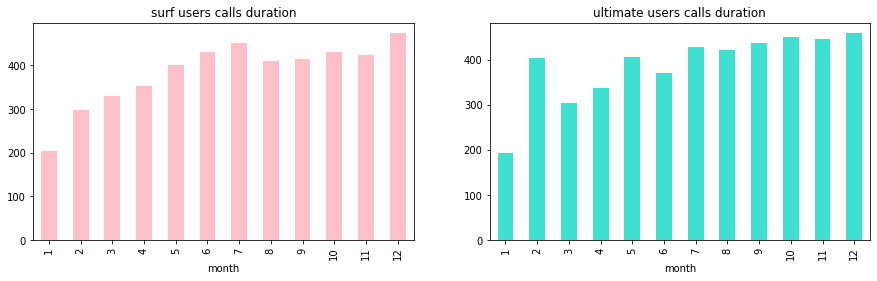

In [42]:
#duración promedio de llamadas por cada plan por cada mes mostrado en una gráfica de barras
plt.subplots(figsize=(15,4))

df_monthly_s.groupby('month')['duration'].mean().plot(kind='bar', color ='pink',ax=plt.subplot(1,2, 1))
plt.title('surf users calls duration')
df_monthly_u.groupby('month')['duration'].mean().plot(kind='bar', color = 'turquoise',ax=plt.subplot(1, 2, 2))
plt.title('ultimate users calls duration')
plt.show()

In [43]:
#observar número de usuarios por mes
df_monthly.groupby('month')['user_id'].count()

month
1       6
2      16
3      35
4      71
5     106
6     144
7     180
8     233
9     280
10    343
11    410
12    469
Name: user_id, dtype: int64

Al analizar el gráfico, pareciera que conforme pasan los meses, suben la duración. Sin embargo, al ver los usuarios que hay en cada mes, se observa que en enero solo 6 usuarios usaban la plataforma, mientras que en diciembre el número de usuarios fue de 469. El incremento del promedio de duración no depende del mes sino del incremento de usuarios.

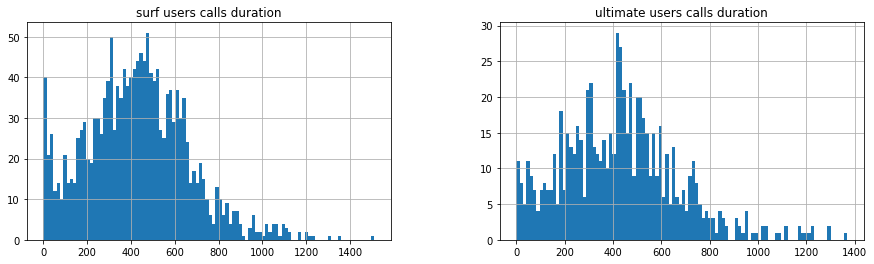

In [44]:
#histograma de la duración de llamadas por plan
plt.subplots(figsize=(15, 4))

df_monthly_s.hist(column='duration',ax=plt.subplot(1,2, 1),bins=100)
plt.title('surf users calls duration')
df_monthly_u.hist(column='duration',ax=plt.subplot(1, 2, 2),bins=100)
plt.title('ultimate users calls duration')
plt.show()

Se obtienen los estadísticos de la duración de las llamadas para analizar los comportamientos de los usuarios de diferentes planes.

In [45]:
df_monthly.groupby('plan')['duration'].describe()

,count,mean,std,min,25%,50%,75%,max
plan,,,,,,,,
surf,1573.0,428.749523,234.453150,0.0,272.0,425.0,576.00,1510.0
ultimate,720.0,430.450000,240.508762,0.0,260.0,424.0,565.25,1369.0


In [46]:
#media y varianza de la duración mensual de llamadas
df_monthly.groupby(['plan','month'])['duration'].describe()

count        mean         std    min     25%    50%     75%  \
plan     month                                                                
surf     1        2.0  203.000000  125.865007  114.0  158.50  203.0  247.50   
         2        9.0  297.000000  228.531179   39.0  244.00  254.0  307.00   
         3       23.0  330.000000  189.233622   35.0  230.50  334.0  397.00   
         4       50.0  351.540000  225.536567   16.0  178.00  339.5  504.25   
         5       77.0  399.584416  244.446763    0.0  186.00  415.0  560.00   
         6       97.0  431.298969  213.524304    0.0  294.00  423.0  559.00   
         7      121.0  449.983471  246.992105    0.0  302.00  454.0  587.00   
         8      162.0  410.111111  233.119381    0.0  257.25  392.0  555.00   
         9      194.0  414.226804  215.860971    0.0  258.50  426.0  550.00   
         10     237.0  429.729958  228.645280    0.0  257.00  432.0  579.00   
         11     283.0  423.325088  227.171789    0.0  268.50  413.0  581.00   
         12     318.0  473.836478  252.248923    0.0  313.50  449.0  613.50   
ultimate 1        4.0  193.500000  128.733575   16.0  139.75  234.0  287.75   
         2        7.0  403.142857  277.289517    0.0  239.00  428.0  570.00   
         3       12.0  304.250000  248.967732   23.0   81.00  251.0  477.50   
         4       21.0  336.857143  186.785783   53.0  217.00  301.0  453.00   
         5       29.0  406.241379  209.382537   22.0  262.00  407.0  480.00   
         6       47.0  370.957447  206.163924    0.0  218.50  399.0  487.50   
         7       59.0  427.067797  269.375898   16.0  202.00  430.0  554.50   
         8       71.0  421.436620  231.614997   12.0  252.00  406.0  544.50   
         9       86.0  437.511628  238.894254   18.0  249.50  434.0  557.50   
         10     106.0  450.735849  232.941861    0.0  301.00  460.5  565.25   
         11     127.0  445.196850  246.156907    0.0  290.00  432.0  585.50   
         12     151.0  459.099338  250.007567    0.0  280.50  436.0  595.00   

                   max  
plan     month          
surf     1       292.0  
         2       811.0  
         3       788.0  
         4      1043.0  
         5      1055.0  
         6      1033.0  
         7      1176.0  
         8      1102.0  
         9      1212.0  
         10     1227.0  
         11     1304.0  
         12     1510.0  
ultimate 1       290.0  
         2       776.0  
         3       711.0  
         4       746.0  
         5       863.0  
         6       797.0  
         7      1188.0  
         8      1292.0  
         9      1232.0  
         10     1215.0  
         11     1197.0  
         12     1369.0

In [47]:
df_monthly.groupby(['plan','month'])['duration'].var(ddof=0)

plan      month
surf      1         7921.000000
          2        46423.555556
          3        34252.434783
          4        49849.408400
          5        58978.190926
          6        45122.601339
          7        60500.925347
          8        54009.185185
          9        46355.773302
          10       52058.078976
          11       51424.664636
          12       63429.426091
ultimate  1        12429.250000
          2        65905.265306
          3        56819.520833
          4        33227.551020
          5        42329.286564
          6        41599.232232
          7        71333.486929
          8        52889.936124
          9        56406.854516
          10       53750.005696
          11       60116.110856
          12       62089.851059
Name: duration, dtype: float64

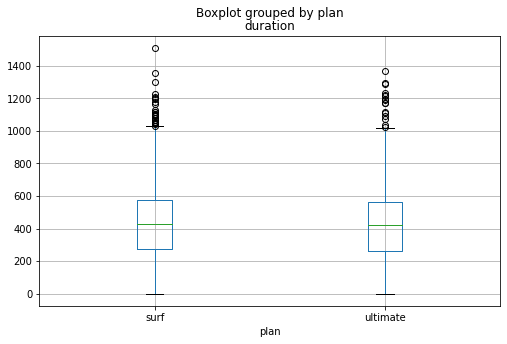

In [48]:
#diagrama de caja para visualizar la distribución de la duración mensual de llamadas.
df_monthly.boxplot(column='duration',by='plan',figsize=(8,5))
plt.show()

In [49]:
#porcentaje de valores atípicos
print('valores atípicos:',round(df_monthly.query('duration>1000').shape[0]/df_monthly.shape[0]*100,2),'%')

valores atípicos: 2.27 %


In [50]:
#visualizar los planes
df_plans

,messages_included,gb_per_month,minutes_included,usd_monthly_pay,usd_per_gb,usd_per_message,usd_per_minute,plan_name
0,50,15.0,500,20,10,0.03,0.03,surf
1,1000,30.0,3000,70,7,0.01,0.01,ultimate


In [51]:
print('Porcentaje de usuarios del plan surf que usaron más del límite:',
      round(df_monthly_s.query('duration>500').shape[0]/df_monthly_s.shape[0]*100,2),'%')

Porcentaje de usuarios del plan surf que usaron más del límite: 35.98 %


In [52]:
print('Porcentaje de usuarios del plan ultimate que usaron más del límite:',
      round(df_monthly_u.query('duration>3000').shape[0]/df_monthly_u.shape[0]*100,2),'%')

Porcentaje de usuarios del plan ultimate que usaron más del límite: 0.0 %


Al analizar los diagramas, se observa un comportamiento similar entre los usuarios de ambos planes. Hay un porcentaje bajo de valores atípicos pero en ellos esta la ligera diferencia; pues las llamadas de los usuarios atípicos del plan surf tienden a durar más del promedio e incluso más que los del plan ultimate. 

Asimismo, el 35.98% de los usuarios del plan surf tienden a sobrepasarse del límite del plan, cosa que genera más ingresos a comparación con el 0% de usuarios del plan ultimate.

### Mensajes

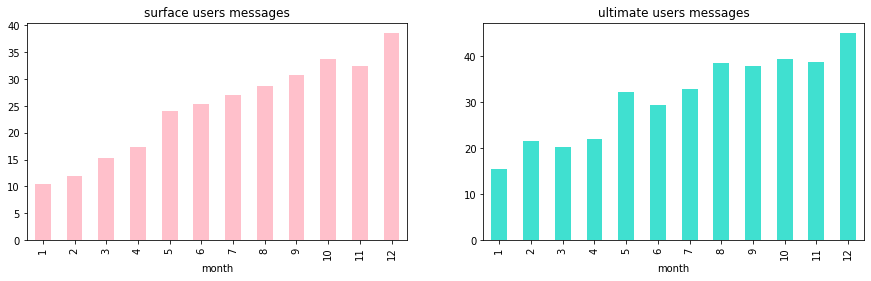

In [53]:
#Número de mensajes promedio de cada plan por cada mes
plt.subplots(figsize=(15,4))
df_monthly_s.groupby('month')['num_mess'].mean().plot(kind='bar', color ='pink',ax=plt.subplot(1,2, 1))
plt.title('surface users messages')
df_monthly_u.groupby('month')['num_mess'].mean().plot(kind='bar', color = 'turquoise',ax=plt.subplot(1, 2, 2))
plt.title('ultimate users messages')
plt.show()

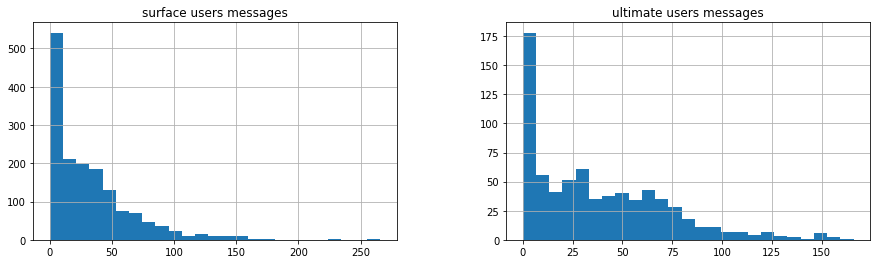

In [54]:
# Comprara el número de mensajes que tienden a enviar cada mes los usuarios de cada plan
plt.subplots(figsize=(15, 4))

df_monthly_s.hist(column='num_mess',ax=plt.subplot(1,2, 1),bins=25)
plt.title('surface users messages')
df_monthly_u.hist(column='num_mess',ax=plt.subplot(1, 2, 2),bins=25)
plt.title('ultimate users messages')
plt.show()

In [55]:
df_monthly.groupby('plan')['num_mess'].describe()

,count,mean,std,min,25%,50%,75%,max
plan,,,,,,,,
surf,1573.0,31.159568,33.566717,0.0,3.0,24.0,47.0,266.0
ultimate,720.0,37.551389,34.767179,0.0,7.0,30.0,61.0,166.0


In [56]:
#media y varianza de mensajes mensuales
df_monthly.groupby(['plan','month'])['num_mess'].describe()

count       mean        std  min    25%   50%    75%    max
plan     month                                                             
surf     1        2.0  10.500000  14.849242  0.0   5.25  10.5  15.75   21.0
         2        9.0  12.000000  19.646883  0.0   0.00   3.0  11.00   58.0
         3       23.0  15.260870  18.616262  0.0   0.00   7.0  25.00   59.0
         4       50.0  17.400000  22.396246  0.0   0.00  10.0  27.75  120.0
         5       77.0  24.012987  29.106652  0.0   0.00  15.0  37.00  149.0
         6       97.0  25.298969  30.247646  0.0   1.00  15.0  36.00  133.0
         7      121.0  27.033058  30.395979  0.0   1.00  20.0  41.00  164.0
         8      162.0  28.777778  32.086064  0.0   2.00  20.0  43.00  156.0
         9      194.0  30.762887  31.683268  0.0   4.00  22.5  48.00  153.0
         10     237.0  33.839662  35.713663  0.0   4.00  26.0  51.00  224.0
         11     283.0  32.385159  32.639608  0.0   4.00  27.0  47.00  180.0
         12     318.0  38.600629  38.185843  0.0   9.00  31.0  57.00  266.0
ultimate 1        4.0  15.500000  17.710637  0.0   1.50  12.5  26.50   37.0
         2        7.0  21.571429  21.869744  0.0  10.00  15.0  24.50   67.0
         3       12.0  20.250000  25.580977  0.0   0.00  12.0  28.00   72.0
         4       21.0  22.047619  23.326972  0.0   5.00  17.0  28.00   77.0
         5       29.0  32.103448  36.018195  0.0   0.00  19.0  60.00  149.0
         6       47.0  29.340426  29.285162  0.0   4.50  21.0  46.50  143.0
         7       59.0  32.830508  30.991741  0.0   4.50  28.0  52.50  149.0
         8       71.0  38.478873  34.588544  0.0   6.00  36.0  64.50  151.0
         9       86.0  37.895349  32.417871  0.0   7.25  31.5  61.00  155.0
         10     106.0  39.443396  34.944331  0.0   8.00  35.0  57.75  153.0
         11     127.0  38.606299  35.109389  0.0   8.50  32.0  63.00  166.0
         12     151.0  45.006623  39.362672  0.0   9.50  41.0  72.00  150.0

In [57]:
df_monthly.groupby(['plan','month'])['num_mess'].var(ddof=0)

plan      month
surf      1         110.250000
          2         343.111111
          3         331.497164
          4         491.560000
          5         836.194637
          6         905.487937
          7         916.279899
          8        1023.160494
          9         998.655117
          10       1270.083997
          11       1061.579568
          12       1453.573207
ultimate  1         235.250000
          2         409.959184
          3         599.854167
          4         518.235828
          5        1252.575505
          6         839.373472
          7         944.208561
          8        1179.517159
          9        1038.698350
          10       1209.586419
          11       1222.963110
          12       1539.158897
Name: num_mess, dtype: float64

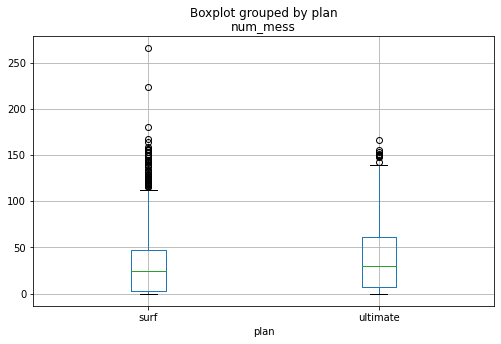

In [58]:
#diagrama de caja para visualizar la distribución del número de mensajes enviados
df_monthly.boxplot(column='num_mess',by='plan',figsize=(8,5))
plt.show()

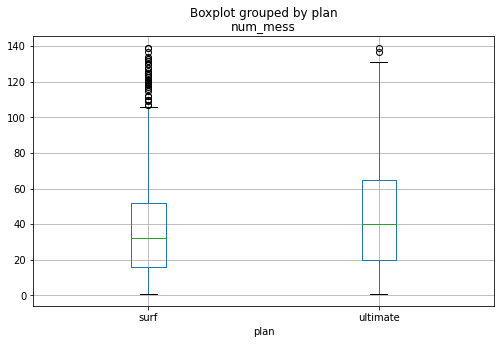

In [59]:
#boxplot de número de mensajes sin valores atípicos
df_monthly.query('0<num_mess<140').boxplot(column='num_mess',by='plan',figsize=(8,5))
plt.show()

In [60]:
print('Porcentaje de usuarios del plan surf que usaron más del límite:',
      round(df_monthly_s.query('num_mess>50').shape[0]/df_monthly_s.shape[0]*100,2),'%')

Porcentaje de usuarios del plan surf que usaron más del límite: 21.61 %


In [61]:
print('Porcentaje de usuarios del plan ultimate que usaron más del límite:',
      round(df_monthly_u.query('num_mess>1000').shape[0]/df_monthly_s.shape[0]*100,2),'%')

Porcentaje de usuarios del plan ultimate que usaron más del límite: 0.0 %


Un número alto de usuarios no envían mensajes. Al eliminar a estos, junto con los valores atípicamente altos, notamos que los clientes con el plan ultimate mandan más mensajes que los del plan surf en promedio. Nuevamente, un porcentaje significativo de usuarios del plan surf sobrepasan el límite del plan mientras que los del ultimate no. 

### Internet

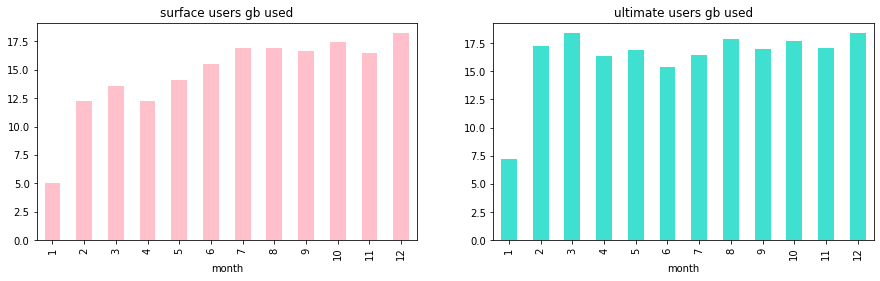

In [62]:
#Cantidad de tráfico de internet consumido por usuarios por plan por cada mes
plt.subplots(figsize=(15,4))
df_monthly_s.groupby('month')['gb_used'].mean().plot(kind='bar', color ='pink',ax=plt.subplot(1,2, 1))
plt.title('surface users gb used')
df_monthly_u.groupby('month')['gb_used'].mean().plot(kind='bar', color = 'turquoise',ax=plt.subplot(1, 2, 2))
plt.title('ultimate users gb used')
plt.show()

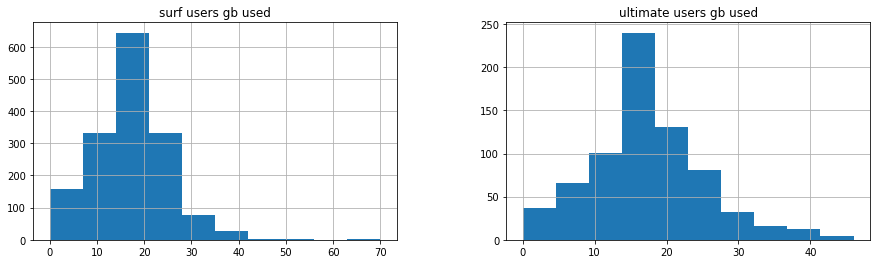

In [63]:
#histograma de los gigas usados
plt.subplots(figsize=(15, 4))

df_monthly_s.hist(column='gb_used',ax=plt.subplot(1,2, 1))
plt.title('surf users gb used')
df_monthly_u.hist(column='gb_used',ax=plt.subplot(1, 2, 2))
plt.title('ultimate users gb used')
plt.show()

In [64]:
df_monthly.groupby('plan')['gb_used'].describe()

,count,mean,std,min,25%,50%,75%,max
plan,,,,,,,,
surf,1573.0,16.670693,7.847522,0.0,12.0,17.0,21.0,70.0
ultimate,720.0,17.306944,7.670108,0.0,13.0,17.0,21.0,46.0


In [65]:
#media y varianza de mensajes mensuales
df_monthly.groupby(['plan','month'])['gb_used'].describe()

count       mean        std  min    25%   50%    75%   max
plan     month                                                            
surf     1        2.0   5.000000   4.242641  2.0   3.50   5.0   6.50   8.0
         2        9.0  12.222222   6.437736  1.0   7.00  12.0  16.00  20.0
         3       23.0  13.565217   7.999012  2.0   6.50  14.0  19.00  30.0
         4       50.0  12.220000   7.497728  0.0   6.25  12.0  17.75  28.0
         5       77.0  14.116883   7.627813  0.0   8.00  14.0  20.00  36.0
         6       97.0  15.484536   6.910308  0.0  12.00  16.0  19.00  37.0
         7      121.0  16.876033   7.840674  0.0  13.00  17.0  21.00  39.0
         8      162.0  16.882716   8.451091  0.0  12.00  17.0  21.00  51.0
         9      194.0  16.690722   7.017167  0.0  13.00  17.0  21.00  37.0
         10     237.0  17.409283   7.792679  0.0  13.00  18.0  21.00  46.0
         11     283.0  16.431095   7.389711  0.0  12.00  17.0  21.00  42.0
         12     318.0  18.238994   8.319305  0.0  14.00  18.0  22.00  70.0
ultimate 1        4.0   7.250000   3.862210  2.0   5.75   8.0   9.50  11.0
         2        7.0  17.285714   6.156684  5.0  16.50  20.0  20.50  22.0
         3       12.0  18.416667  11.774073  2.0   8.25  21.0  28.75  36.0
         4       21.0  16.333333   9.264628  3.0   9.00  16.0  21.00  37.0
         5       29.0  16.862069   7.361697  3.0  14.00  17.0  21.00  33.0
         6       47.0  15.425532   8.298100  2.0  10.50  15.0  20.00  38.0
         7       59.0  16.491525   8.015874  1.0  12.00  15.0  21.00  38.0
         8       71.0  17.845070   7.618864  1.0  14.00  18.0  21.00  40.0
         9       86.0  17.011628   6.874495  4.0  13.00  16.5  19.75  37.0
         10     106.0  17.716981   7.389510  0.0  13.00  17.0  21.00  46.0
         11     127.0  17.118110   7.375005  1.0  13.00  17.0  21.00  42.0
         12     151.0  18.397351   7.670793  1.0  14.00  17.0  22.00  46.0

In [66]:
df_monthly.groupby(['plan','month'])['gb_used'].var(ddof=0)

plan      month
surf      1          9.000000
          2         36.839506
          3         61.202268
          4         55.091600
          5         57.427897
          6         47.260070
          7         60.968103
          8         70.980072
          9         48.986821
          10        60.469618
          11        54.414863
          12        68.993196
ultimate  1         11.187500
          2         32.489796
          3        127.076389
          4         81.746032
          5         52.325803
          6         67.393391
          7         63.165182
          8         57.229518
          9         46.709167
          10        54.089712
          11        53.962428
          12        58.451384
Name: gb_used, dtype: float64

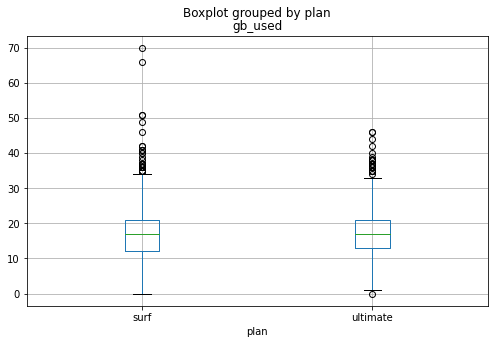

In [67]:
#Diagrama de caja para visualizar la distribución del consumo de internet
df_monthly.boxplot(column='gb_used',by='plan',figsize=(8,5))
plt.show()

In [68]:
print('Porcentaje de usuarios del plan surf que usaron más del límite:',
      round(df_monthly_s.query('gb_used>15').shape[0]/df_monthly_s.shape[0]*100,2),'%')

Porcentaje de usuarios del plan surf que usaron más del límite: 57.91 %


In [69]:
print('Porcentaje de usuarios del plan ultimate que usaron más del límite:',
      round(df_monthly_u.query('gb_used>30').shape[0]/df_monthly_u.shape[0]*100,2),'%')

Porcentaje de usuarios del plan ultimate que usaron más del límite: 5.69 %


En general, los datos de los usuarios de ambos planes son muy similares, sin embargo los valores atípicos son los que crean la diferencia entre ellos. Los usuarios del plan Surf tienen consumos de hasta 70 gigas, mientras que los de ultimate llegaron hasta los 46. Asimismo, más de la mitad de los usuarios del plan Surf tienden a sobrepasar el límite del plan mientras que solo el 5.69% de los del plan ultimate sobrepasaron el límite.

## Ingreso

Se analizan los ingresos generados por los usuarios de ambos planes con sus valores estdísticos asi como con sus gráficas.

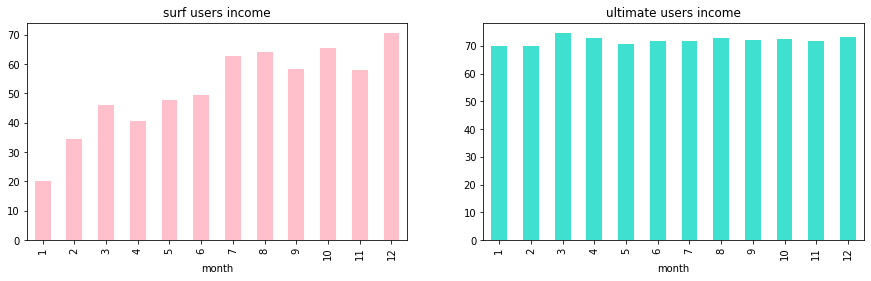

In [70]:
#Promedio de ingresos por cada plan por cada mes
plt.subplots(figsize=(15,4))

df_monthly_s.groupby('month')['income'].mean().plot(kind='bar', color ='pink',ax=plt.subplot(1,2, 1))
plt.title('surf users income')
df_monthly_u.groupby('month')['income'].mean().plot(kind='bar', color = 'turquoise',ax=plt.subplot(1, 2, 2))
plt.title('ultimate users income')
plt.show()

Tomando en cuenta que inicialmente habia pocos usuarios, los ingresos del plan surf fueron incrementando conforme subieron los usuarios, sin embargo, el plan ultimate se mantuvo constante a pesar de que los usuarios incrementaron.

Esto confirma que mientras más usuarios hay con el plan surf, más usuarios sobrepasan el límite mientras que los usuarios del ultimate, normalmente se mantienen dentro del plan.

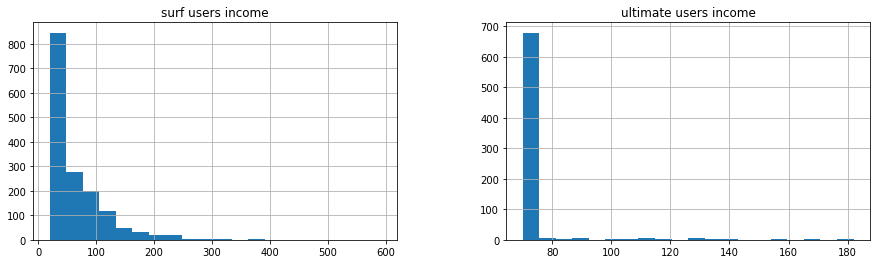

In [71]:
#histograma del ingreso 
plt.subplots(figsize=(15, 4))

df_monthly_s.hist(column='income',ax=plt.subplot(1,2, 1),bins=20)
plt.title('surf users income')
df_monthly_u.hist(column='income',ax=plt.subplot(1, 2, 2),bins=20)
plt.title('ultimate users income')
plt.show()

In [72]:
df_monthly.groupby('plan')['income'].describe()

,count,mean,std,min,25%,50%,75%,max
plan,,,,,,,,
surf,1573.0,60.706408,55.388042,20.0,20.0,40.36,80.36,590.37
ultimate,720.0,72.313889,11.395108,70.0,70.0,70.00,70.00,182.00


In [73]:
df_monthly.groupby('plan')['income'].var(ddof=0)

plan
surf        3065.884844
ultimate     129.668140
Name: income, dtype: float64

In [74]:
#media y varianza de ingresos mensuales
df_monthly.groupby(['plan','month'])['income'].describe()

count       mean        std   min    25%     50%      75%  \
plan     month                                                              
surf     1        2.0  20.000000   0.000000  20.0  20.00  20.000  20.0000   
         2        9.0  34.396667  20.694833  20.0  20.00  29.570  30.0000   
         3       23.0  45.941304  38.884747  20.0  20.00  20.000  60.0600   
         4       50.0  40.710600  34.625979  20.0  20.00  20.000  49.4050   
         5       77.0  47.628182  44.356962  20.0  20.00  21.740  71.0200   
         6       97.0  49.276289  44.597243  20.0  20.00  30.150  60.4500   
         7      121.0  62.674050  54.253004  20.0  20.42  40.330  86.5900   
         8      162.0  63.931173  59.895700  20.0  20.00  41.980  87.4025   
         9      194.0  58.271495  47.546240  20.0  20.00  40.045  81.5150   
         10     237.0  65.421224  56.553007  20.0  20.00  50.000  83.2700   
         11     283.0  58.004276  49.941788  20.0  20.00  40.000  80.0000   
         12     318.0  70.557044  67.855809  20.0  23.60  50.000  90.3150   
ultimate 1        4.0  70.000000   0.000000  70.0  70.00  70.000  70.0000   
         2        7.0  70.000000   0.000000  70.0  70.00  70.000  70.0000   
         3       12.0  74.666667  12.062966  70.0  70.00  70.000  71.7500   
         4       21.0  73.000000  10.972693  70.0  70.00  70.000  70.0000   
         5       29.0  70.724138   3.899602  70.0  70.00  70.000  70.0000   
         6       47.0  71.638298   8.661322  70.0  70.00  70.000  70.0000   
         7       59.0  71.898305  10.221166  70.0  70.00  70.000  70.0000   
         8       71.0  72.859155  12.442204  70.0  70.00  70.000  70.0000   
         9       86.0  72.034884   8.714353  70.0  70.00  70.000  70.0000   
         10     106.0  72.311321  13.023322  70.0  70.00  70.000  70.0000   
         11     127.0  71.708661   9.729770  70.0  70.00  70.000  70.0000   
         12     151.0  73.291391  14.589763  70.0  70.00  70.000  70.0000   

                   max  
plan     month          
surf     1       20.00  
         2       70.00  
         3      170.00  
         4      150.00  
         5      231.95  
         6      240.00  
         7      260.63  
         8      380.00  
         9      240.78  
         10     330.00  
         11     290.36  
         12     590.37  
ultimate 1       70.00  
         2       70.00  
         3      112.00  
         4      119.00  
         5       91.00  
         6      126.00  
         7      126.00  
         8      140.00  
         9      119.00  
         10     182.00  
         11     154.00  
         12     182.00

In [75]:
df_monthly.groupby(['plan','month'])['income'].var(ddof=0)

plan      month
surf      1           0.000000
          2         380.689867
          3        1446.283359
          4        1174.979234
          5        1941.987586
          6        1968.409778
          7        2919.062885
          8        3565.349871
          9        2248.992170
          10       3184.747918
          11       2485.368865
          12       4589.931589
ultimate  1           0.000000
          2           0.000000
          3         133.388889
          4         114.666667
          5          14.682521
          6          73.422363
          7         102.701523
          8         152.628050
          9          75.056923
          10        168.006853
          11         93.922996
          12        211.451515
Name: income, dtype: float64

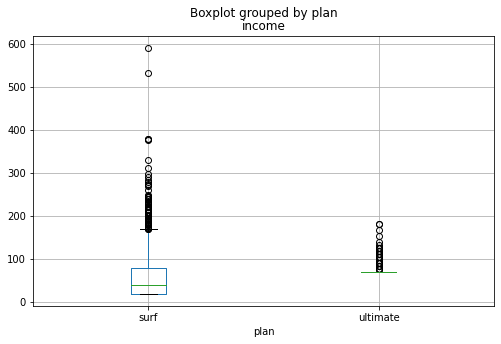

In [76]:
#Diagrama de caja para visualizar la distribución del consumo de internet
df_monthly.boxplot(column='income',by='plan',figsize=(8,5))
plt.show()

Ingresos totales de cada plan

In [77]:
print('Ingreso total del 2018 del plan surf:',df_monthly_s['income'].sum())
print('Ingreso total del 2018 del plan ultimate:',df_monthly_u['income'].sum())

Ingreso total del 2018 del plan surf: 95491.18

Ingreso total del 2018 del plan ultimate: 52066.0


In [78]:
print('usuarios que usaron el plan surf en el 2018:',len(df_monthly_s['user_id'].unique() ) )
print('usuarios que usaron el plan ultimate en el 2018:',len(df_monthly_u['user_id'].unique() ) )

usuarios que usaron el plan surf en el 2018: 333

usuarios que usaron el plan ultimate en el 2018: 157


## Probar las hipótesis estadísticas.

A continuación se prueban distintas hipótesis

### Hipótesis sobre igualdad de medias en los distintos planes

La primer hipótesis a probar es que el ingreso promedio mensual del plan surf es diferente al del ultimate.

**Hipotesis nula:** el ingreso promedio mensual del plan surf es igual al del ultimate

**Hipotesis alterna:** el ingreso promedio mensual del plan surf es diferente al del ultimate

**Prueba estadística:** Hipótesis sobre la igualdad de las medias de dos poblaciones

**Valor alfa:** 5%

In [82]:
alpha = 0.05 

#Prueba de hipótesis 1
h1 = st.ttest_ind(df_monthly_s['income'], df_monthly_u['income'],equal_var = False)
print('p-value: ', h1.pvalue)

if h1.pvalue < alpha:
    print("Se rechaza la hipótesis nula")
else:
    print("No se rechaza la hipótesis nula") 

p-value:  3.17039054811355e-15

Se rechaza la hipótesis nula


Hay una diferencia significativa entre los ingresos mensuales promedio de los planes.

### Hipótesis sobre igualdad de medias en distintas regiones

La segunda hipótesis a probar es que el ingreso promedio de los usuarios del área NY-NJ es diferente al de los usuarios de otras regiones.

**Hipotesis nula:** el ingreso promedio de los usuarios del área NY-NJ es igua al de los usuarios de otras regiones.

**Hipotesis alterna:** el ingreso promedio de los usuarios del área NY-NJ es diferente al de los usuarios de otras regiones

**Prueba estadística:** Hipótesis sobre la igualdad de las medias de dos poblaciones

**Valor alfa:** 5%

In [81]:
df_monthly_s.query('city == "New York-Newark-Jersey City, NY-NJ-PA MSA"')

#Prueba de hipótesis 2
h2 = st.ttest_ind(df_monthly.query('city == "New York-Newark-Jersey City, NY-NJ-PA MSA"')['income'], 
                  df_monthly.query('city != "New York-Newark-Jersey City, NY-NJ-PA MSA"')['income'],equal_var = False)

print('p-value: ', h2.pvalue)

if h2.pvalue < alpha:
    print("Se rechaza la hipótesis nula")
else:
    print("No se rechaza la hipótesis nula") 

p-value:  0.03352561588530014

Se rechaza la hipótesis nula


Hay una diferencia significativa entre los ingresos de los usuarios del área NY-NJ y el resto.

## Conclusión general

En las tablas de datos iniciales no hubo valores auentes a excepción de la columna `churn_date` de la tabla de los usuarios; la cuál representa la fecha en que el usuario dejo de usar el servicio. Sin embargo, la ausencia de la fecha se tomo como que el usuario sigue usando el servicio. Asimismo, los análisis hechos no requerian de esta información. 

Adicionalmente a esto, a las tablas originales se les hicieron cambios como los redondeos hacia arriba que se hacen al cobrar y se modificaron columnas referentes al internet para que todas estuvieran en unidades de gigas, que es la unidad de cobro. 

En cuanto a las hipótesis análizadas, los resultados fueron que el ingreso promedio mensual del plan surf es diferente al del ultimate y que el ingreso promedio de los usuarios del área NY-NJ es diferente al de los usuarios de otras regiones.

En cuanto al propósito de análisis, que es saber cuál de los planes genera más ingresos, se sabe que:

- El ingreso promedio mensual por usuario es
 - 60.71 USD en el plan surf
 - 72.31 USD en el plan ultimate

- Los ingresos totales del 2018 fueron
 - 95491.18 USD del plan surf
 - 52066.00 USD del plan ultimate
 
- Usuarios en el 2018
 - 333 en el plan surf 
 - 157 en el plan ultimate

Los ingresos totales muestran que hubo más ingresos por el plan surf que por el ultimate, pero este ultimo tiene la mitad de usuarios que el primero. Tomando en cuenta que el promedio de ingresos del plan ultimate es mayor a los del plan surf, se sugiere aumentar el presupuesto de publicidad del plan ultimate para atraer más usuarios a este plan y así tener más ingresos anuales con un promedio de ingreso por usuario cercano a 70 USD.